## <span style="color:green"> Notebook - Inversion of composition from electrical conductivity</span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

Inversion module currently involves only inverting for conductivit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pide
from pide.inversion import conductivity_solver_single_param
from pide.geodyn.geotherm import calculate_hasterok2011_geotherm

In [2]:
moho = 38 #km
max_depth = 250

T, depth, p, idx_LAB = calculate_hasterok2011_geotherm(SHF = 36, T_0 =25.0,max_depth = max_depth, moho = moho)

In [3]:
p_obj = pide.pide() #creating the initial object
p_obj.set_temperature(T)
p_obj.set_pressure(p)

p_obj.set_composition_solid_mineral(ol = 0.65, opx = 0.2, cpx = 0.1, garnet = 0.05)
p_obj.set_solid_phs_mix_method(2)


In [4]:
p_obj.set_mantle_water_solubility(ol = 4,opx = 3, cpx = 0, garnet = 0)
p_obj.set_mantle_water_partitions(opx_ol = 3, cpx_ol = 4, garnet_ol = 0)
p_obj.revalue_arrays()

In [5]:
p_obj.set_parameter('ti_ol', 0.1)
max_water = p_obj.calculate_bulk_mantle_water_solubility(method = 'array')

In [6]:
cond_list_to_invert = np.ones(len(T)) * 1e4
cond_list_to_invert[75:100] = 1000
cond_list_to_invert[100:150] = 100
cond_list_to_invert[150:] = 50
cond_list_to_invert = 1.0 / cond_list_to_invert #converting to conductivity

In [7]:
c_list, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_list_to_invert, param_name = 'bulk_water', upper_limit_list = max_water,
lower_limit_list= np.zeros(len(max_water)), search_start = 10, acceptence_threshold = 0.5, num_cpu = 5)

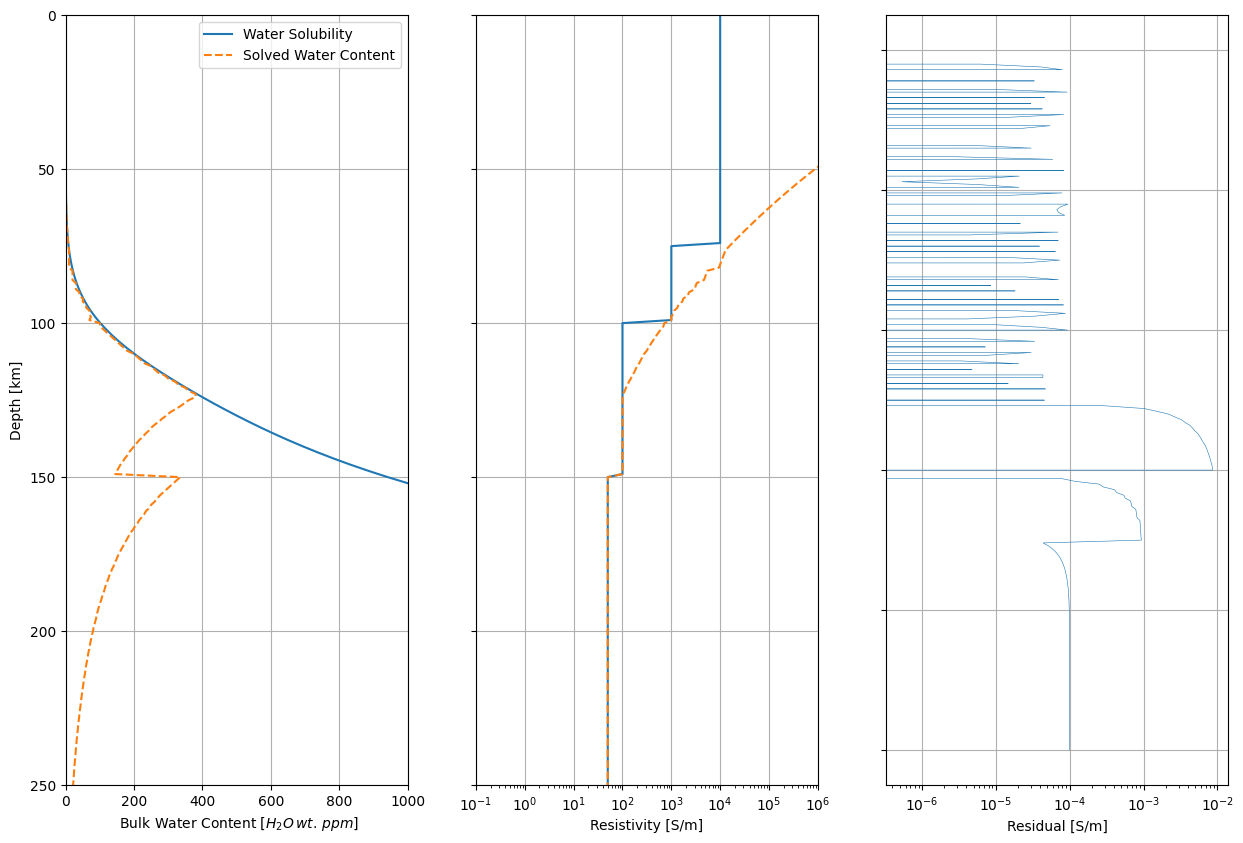

In [8]:
p_obj.set_bulk_water(c_list)
p_obj.mantle_water_distribute(method = 'array')
cond_calced = p_obj.calculate_conductivity(method = 'array')

fig = plt.figure(figsize = (15,10))
ax = plt.subplot(131)
# ax.plot(cond_list,object.T,label = 'data')
# ax.plot(cond_calced,object.T, label = 'calced')
ax.plot(max_water,depth, label = 'Water Solubility')
ax.plot(c_list,depth,linestyle = '--', label = 'Solved Water Content')
ax.set_ylim(np.amax(depth),np.amin(depth))
ax.set_xlim(0,1000)
ax.set_ylabel('Depth [km]')
ax.set_xlabel(r' Bulk Water Content [$H_2O \, wt. \, ppm$]')
ax.legend()
ax.grid()

ax2 = plt.subplot(132)
ax2.plot(1.0/cond_list_to_invert,depth)
ax2.plot(1.0/cond_calced,depth,linestyle = '--')
ax2.set_xscale('log')
ax2.set_ylim(np.amax(depth),np.amin(depth))
ax2.set_xlim(0.1,1e6)
ax2.set_yticklabels([])
ax2.set_xlabel(r'Resistivity [$\Omega m$]')
ax2.grid()

ax3 = plt.subplot(133)
ax3.plot(residual_list, depth, lw = 0.4)
ax3.set_yticklabels([])
ax3.set_xlabel('Residual [S/m]')
ax3.set_xscale('log')
ax3.grid()

plt.show()

Now let's solve the same environment for how much phlogopite needed, first let's set the bulk water content as zero and redistribute.

In [25]:
p_obj.reset()

p_obj.set_temperature(T)
p_obj.set_pressure(p)
p_obj.set_composition_solid_mineral(ol = 0.65, opx = 0.2, cpx = 0.1, garnet = 0.05)
p_obj.set_solid_phs_mix_method(2)
p_obj.revalue_arrays()

Now, let's solve for phlogopite content as put in the pide as mica_frac. Setting the inversion as search start increment of 0.005 fraction to search between 0 to 0.1 fraction.

In [26]:
c_list, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_list_to_invert, param_name = 'mica_frac', upper_limit_list = np.ones(len(T)) * 0.1,
lower_limit_list= np.zeros(len(T)), search_start = 0.01, acceptence_threshold = 0.001, num_cpu = 4)

cond_calced_phlg = p_obj.calculate_conductivity()

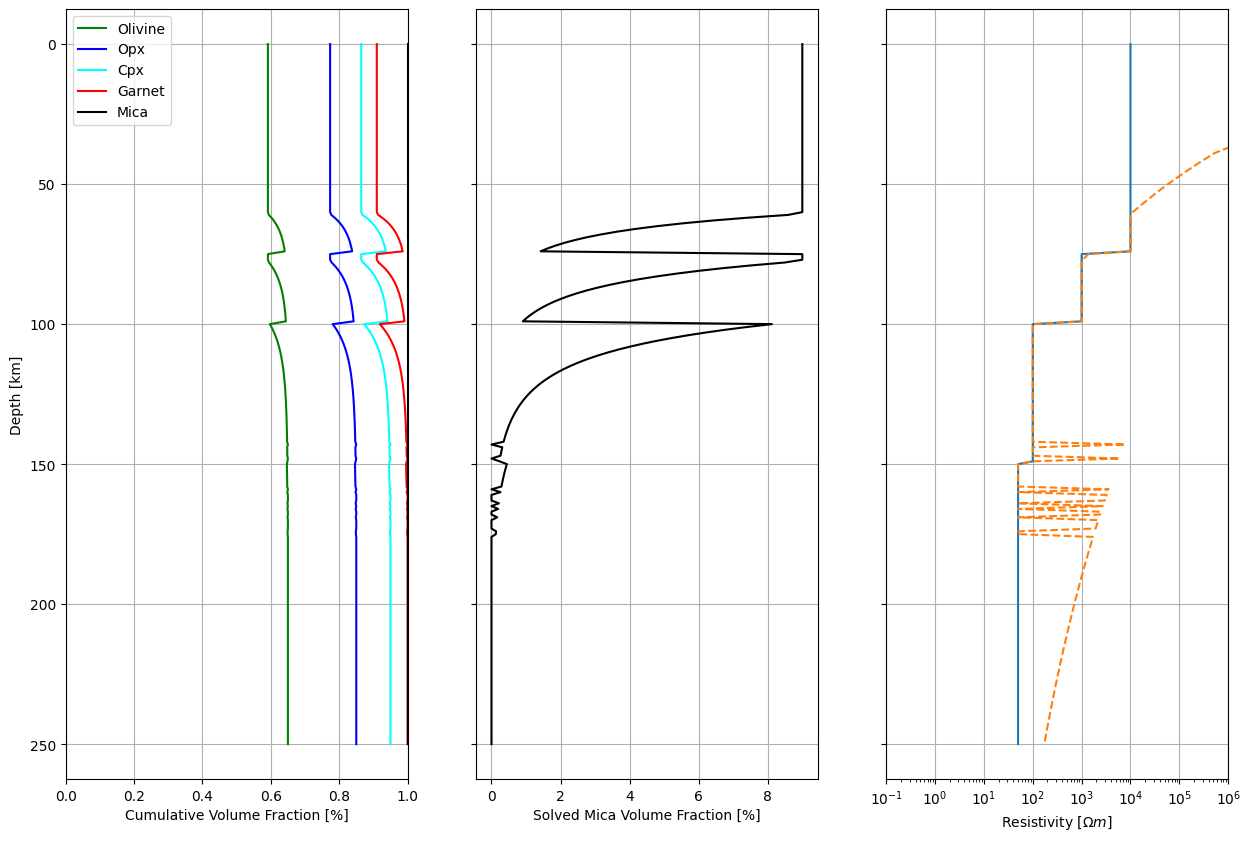

In [32]:
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(131)
# ax.plot(cond_list,object.T,label = 'data')
# ax.plot(cond_calced,object.T, label = 'calced')

ax.plot(p_obj.ol_frac,depth,color = 'g',label = 'Olivine')
ax.plot(p_obj.ol_frac + p_obj.opx_frac,depth, color = 'b',label = 'Opx')
ax.plot(p_obj.ol_frac + p_obj.opx_frac + p_obj.cpx_frac,depth, color = 'cyan',label = 'Cpx')
ax.plot(p_obj.ol_frac + p_obj.opx_frac + p_obj.cpx_frac + p_obj.garnet_frac,depth, color = 'r',
        label = 'Garnet')
ax.plot(p_obj.ol_frac + p_obj.opx_frac + p_obj.cpx_frac + p_obj.garnet_frac + p_obj.mica_frac,
        depth, color = 'k',label = 'Mica')
ax.set_xlim(0,1)
ax.legend()
ax.grid()
ax.set_xlabel('Cumulative Volume Fraction [%]')
ax.set_ylabel('Depth [km]')
ax.invert_yaxis()


ax2 = plt.subplot(132)
ax2.plot(p_obj.mica_frac * 1e2, depth, color = 'k')
ax2.invert_yaxis()
ax2.set_yticklabels([])
ax2.grid()
ax2.set_xlabel('Solved Mica Volume Fraction [%]')

# plt.savefig('2.png',dpi = 300)

ax3 = plt.subplot(133)
ax3.plot(1.0/cond_list_to_invert,depth)
ax3.plot(1.0/cond_calced_phlg,depth, linestyle = '--')
ax3.set_xscale('log')
ax3.set_yticklabels([])
ax3.invert_yaxis()
ax3.set_xlabel(r'Resistivity [$\Omega m$]')
ax3.grid()
ax3.set_xlim(0.1,1e6)
plt.show()